<h1>Is Same Room Classifier Research</h1>
<p>This notebook will lead you through the process of training a model for classifying if two images are the images of the same room or not.</p>
<p>Before you begin, you should have all the data needed already at hand and in the right format, as well as correct drivers and environment (check README.md for more info).</p>

<h3>Set environment variable to increase stability on some systems (optionally)

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

<h3>Import libraries

In [22]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import json
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import concurrent.futures

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.client import device_lib
from tensorflow.python.ops.math_ops import xdivy_eager_fallback

from keras import datasets, layers, models, Model
from keras.models import load_model, Model
from keras.applications import resnet
from keras.layers import Input, Flatten, Dense, Dropout, Lambda
from keras.optimizers import RMSprop
from keras import backend as K
from keras.utils import plot_model
import keras.utils as image

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams

import datetime
from data_load.whale_data import load_data

import coremltools

scikit-learn version 1.3.1 is not supported. Minimum required version: 0.17. Maximum required version: 1.1.2. Disabling scikit-learn conversion API.
TensorFlow version 2.14.1 has not been tested with coremltools. You may run into unexpected errors. TensorFlow 2.12.0 is the most recent version that has been tested.


<h3>Start Tensorboard session (optionally)

In [3]:
%load_ext tensorboard

<h3>Set paths and constants</h3> 
<p>Json-files should have three columns: img1, img2 and answer, where img1 and img2 contains names of images (including extensions), answer - whether those images are same (1) or different (0).</p>

In [4]:
PATH_CSV = 'Data/train.csv'
PATH_PHOTOS = 'Data/train'

TEST_JSON = 'Data/Test_Json_97_Full.json'
PATH_TEST_PHOTOS = 'Data/Test_Photos_97_Full'

PATH_MODELS = 'Data/models/'

TEST_SIZE = 0.1
VAL_SIZE = 0.2

<h3>Read and split data</h3>
<p>Here, train data is split into train and validation datasets in a 3 to 1 ratio (originally this created a train/validation/test split of 0.6/0.2/0.2). Because we have test data saved completely separate from our train data &#150; no test dataset is taken from the train data.</p>
<p><font size='2'>Optionally: change '_' variable (wich represents test dataset taken from train data) to something meaningfull and use it in the code.</font></p>

In [5]:
data = load_data(table_path=PATH_CSV, images_directory=PATH_PHOTOS)

val_size_relative = VAL_SIZE/(1-TEST_SIZE)

train_data, test_data = train_test_split(data, random_state=42,
                                         test_size=TEST_SIZE)
train_data, validate_data = train_test_split(train_data, random_state=42,
                                        test_size=val_size_relative)

<h3>Define preprocessing functions</h3>

In [6]:
def load_and_preprocess(path, scale=(112,112)):
  img= image.load_img(path, target_size=scale)
  img_array = image.img_to_array(img)
  preprocessed_img = resnet.preprocess_input(img_array)
  return preprocessed_img

def load_and_preprocess_row(row, final_scale=(224,224)):
  img1_array = load_and_preprocess(row[0][0], final_scale)
  img2_array = load_and_preprocess(row[0][1], final_scale)
  return img1_array, img2_array

<h3>Define data sequence class</h3>
<p>Sequences are generating data dynamically, wich allows us to work with giant datasets, while remaining multiprocess-safe.</p>

In [7]:
class pair_sequence(keras.utils.Sequence):
  def __init__(self, data, batch_size=32, scale=(224,224,3),
                 n_classes=2, shuffle=True):
        self.indexes = None
        self.data = data
        self.batch_size = batch_size
        self.scale = scale
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

  def __len__(self):
        '''Denotes the number of batches per epoch'''
        return int(np.floor(len(self.indexes) / self.batch_size))

  def __getitem__(self, index):
        '''Generate one batch of data'''
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        batch_data = [self.data[k] for k in indexes]
        X, y = self.__data__generation(batch_data)
        return X, y

  def on_epoch_end(self):
        '''Updates indexes after each epoch'''
        self.indexes = np.arange(len(self.data))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

  def __data__generation(self, batch_data):
    first = np.empty((self.batch_size, *self.scale))
    second = np.empty((self.batch_size, *self.scale))

    y = np.empty((self.batch_size), dtype=float)

    for count, row in enumerate(batch_data):
      first_img, second_img= load_and_preprocess_row(row,
                                          final_scale=self.scale)
      first[count] = first_img
      second[count] = second_img

      y[count] = row[1]
    X = {'img_1': first, 'img_2': second}
    return X, y

<h3>Use ResNet152 as a pretrained model</h3>

In [8]:
target_shape = (224, 224)

base_cnn = resnet.ResNet152(
    weights="imagenet", input_shape=target_shape + (3,), 
    include_top=False, pooling='avg'
)

2023-11-29 11:31:27.237259: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-29 11:31:27.241005: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-29 11:31:27.241039: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-29 11:31:27.242247: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-29 11:31:27.242274: I tensorflow/compile

<h3>Use some intermediate ResNet layers as output in conjunction with regular output</h3>
<p>This allows our head model to look not only on high-level features, but on the low-level ones too.</p>
<p><font size='2'>Optionally: change layer_to_snap_names to experiment wich layers work best.</font></p>

In [9]:
def snap_and_prepare_layer(cnn_to_snap_out_of, layer_name):
    snapped_layer = layers.GlobalAveragePooling2D()(cnn_to_snap_out_of.get_layer(layer_name).output)
    output = layers.Flatten()(snapped_layer)
    return output

layer_to_snap_names = ['conv4_block36_out', 'conv4_block27_out', 
                       'conv4_block18_out', 'conv4_block9_out', 
                       'conv3_block8_out','conv3_block4_out', 
                       'conv2_block3_out']
all_outputs=[]

base_output = layers.Flatten()(base_cnn.output)
all_outputs.append(base_output)

for name in layer_to_snap_names:
    all_outputs.append(snap_and_prepare_layer(base_cnn, name))

embedding = Model(base_cnn.input, all_outputs, name="Embedding")

<h3>Freeze training of all layers in ResNet</h3>

In [10]:
trainable = False
for layer_nested in embedding.layers:
    layer_nested.trainable = trainable

<h3>Define functions that help in creating head of the model</h3>
<p>Every pair of outputs (because seamese architecture will be used) of ResNet model, is going through some lambda layers, and every output of that goes through a small sequence of primitive layers, and all outputs are then concatenated.</p>

In [11]:
def simple_dense_subblock(starting_layer, units, dropout, block_number, subblock_name):
    starting_layer = layers.Dense(units, activation='relu', name=f'block{block_number}_sub{subblock_name}_dense1')(starting_layer)
    starting_layer = layers.BatchNormalization(name=f'block{block_number}_sub{subblock_name}_bn')(starting_layer)
    starting_layer = layers.Dropout(dropout, name=f'block{block_number}_sub{subblock_name}_dropout1')(starting_layer)
    starting_layer = layers.Dense(units, activation='relu', name=f'block{block_number}_sub{subblock_name}_dense2')(starting_layer)
    starting_layer = layers.Dropout(dropout, name=f'block{block_number}_sub{subblock_name}_dropout2')(starting_layer)
    return starting_layer

def lambda_block(inputs, block_number, units):
    x1 = Lambda(lambda x: x[0] * x[1], name=f'block{block_number}_mult')(inputs)
    x1 = simple_dense_subblock(x1, units, 0.5, block_number, 'Mult')
    x2 = Lambda(lambda x: x[0] + x[1], name=f'block{block_number}_add')(inputs)
    x2 = simple_dense_subblock(x2, units, 0.5, block_number, 'Add')
    x3 = Lambda(lambda x: K.abs(x[0] - x[1]), name=f'block{block_number}_abs')(inputs)
    x4 = Lambda(lambda x: K.square(x), name=f'block{block_number}_square')(x3)
    x3 = simple_dense_subblock(x3, units, 0.5, block_number, 'Abs')
    x4 = simple_dense_subblock(x4, units, 0.5, block_number, 'Square')
    x5 = layers.Concatenate(name=f'block{block_number}_Concat')(inputs)
    x5 = simple_dense_subblock(x5, units, 0.3, block_number, 'Concat')
    return [x1, x2, x3, x4, x5]

def head_block(input_1, input_2):
    head_ouput = []
    for idx in range(min(len(input_1), len(input_2))):
        units = int(list(input_1[idx].shape)[1]/8)
        head_ouput.extend(lambda_block([input_1[idx], input_2[idx]], idx, units))
    output_layer = layers.Concatenate()(head_ouput)
    return output_layer

<h3>Create model with seamese architecture</h3>

In [12]:
img_1_input = layers.Input(name="img_1", shape=target_shape + (3,))
img_2_input = layers.Input(name="img_2", shape=target_shape + (3,))

all_outputs_1 = embedding(img_1_input)
all_outputs_2 = embedding(img_2_input)

output = head_block(all_outputs_1, all_outputs_2)

output = layers.Dropout(0.2)(output)
output = layers.Dense(1)(output)

model = Model([img_1_input, img_2_input], output)

<h3>Plot the model (optionally)</h3>
<p>Installing graphviz may be required. If model is not shown, see instructions <a href="https://graphviz.gitlab.io/download/">here</a>, and restart the kernel</p>


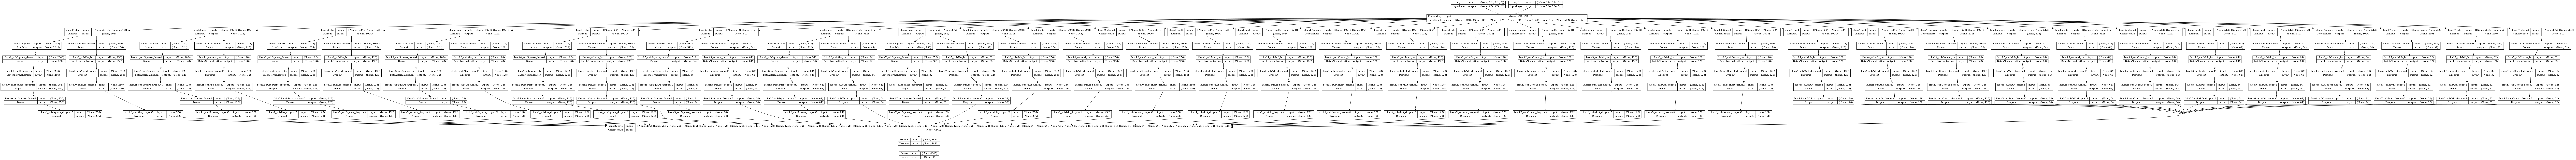

In [13]:
tf.keras.utils.plot_model(model, to_file='siamese_model.png', show_shapes=True)

<h3>Initialize data sequences</h3>
<p>Change in batch_size may be needed in some systems, depending on RAM<p>

In [14]:
train_sequence = pair_sequence(train_data, batch_size=16, shuffle=True, scale=(224, 224, 3))
validate_sequence = pair_sequence(validate_data, batch_size=16, shuffle=True, scale=(224, 224, 3))
test_sequence = pair_sequence(test_data, batch_size=16, shuffle=False, scale=(224, 224, 3))

<h3>Initialize optimiser</h3>

In [15]:
rms = keras.optimizers.RMSprop(learning_rate=1e-4)

<h3>Compile the model</h3>

In [16]:
model.compile(loss=keras.losses.BinaryCrossentropy(),
              optimizer=rms, metrics=['binary_accuracy'])

<h3>Initialize callback functions</h3>

In [17]:
checkpoint_filepath = 'Data/models/tmp/checkpoint'
log_dir='logs/fit/'+datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_binary_accuracy',
    mode='max',
    save_best_only=True)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

<h3>Train the model</h3>
<p>On some low-end systems, using tensorboard_callback may crash the kernel. Delete it from the list of callbacks, if this happens.</p> 

In [18]:
history = model.fit(
    train_sequence,
    initial_epoch=0,
    epochs=50,
    validation_data = validate_sequence,
    steps_per_epoch=len(train_sequence),
    use_multiprocessing=True,
    validation_steps=len(validate_sequence),
    verbose=1,
    workers=4,
    max_queue_size=10,
    callbacks=[model_checkpoint_callback, tensorboard_callback])

Epoch 1/50


2023-11-29 11:31:58.007282: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-29 11:32:02.272170: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f4c88202840 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-29 11:32:02.272217: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti Laptop GPU, Compute Capability 8.6
2023-11-29 11:32:02.278178: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-29 11:32:02.330415: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


935/935 [==============================] - 262s 246ms/step - loss: 5.1249 - binary_accuracy: 0.5865 - val_loss: 3.7841 - val_binary_accuracy: 0.6723
Epoch 2/50
935/935 [==============================] - 225s 240ms/step - loss: 4.2014 - binary_accuracy: 0.6696 - val_loss: 3.4575 - val_binary_accuracy: 0.7182
Epoch 3/50
935/935 [==============================] - 228s 243ms/step - loss: 3.7336 - binary_accuracy: 0.7060 - val_loss: 3.0257 - val_binary_accuracy: 0.7488
Epoch 4/50
935/935 [==============================] - 229s 244ms/step - loss: 3.3856 - binary_accuracy: 0.7344 - val_loss: 2.9500 - val_binary_accuracy: 0.7608
Epoch 5/50
935/935 [==============================] - 228s 244ms/step - loss: 3.1971 - binary_accuracy: 0.7499 - val_loss: 3.0266 - val_binary_accuracy: 0.7652
Epoch 6/50
935/935 [==============================] - 228s 243ms/step - loss: 3.0096 - binary_accuracy: 0.7660 - val_loss: 2.8879 - val_binary_accuracy: 0.7757
Epoch 7/50
935/935 [==============================]

<h3>If Tensorboard was used, view the training process (optionally)</h3>

In [19]:
%tensorboard --logdir logs/fit

<h3>Save or Load models (optionally)</h3>
<p>Input from the user is needed to prevent accidental overwriting.</p>

In [20]:
if input('Are you sure you want to save the model?') == 'yes':
    model.save(PATH_MODELS+'CNN.h5', save_format='h5')
else:
    print('Not Saved')

/home/alex/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
if input('Are you sure you want to load the model?') == 'yes':
    model = keras.models.load_model(PATH_MODELS+'model_name.h5')
else:
    print('Not Loaded')

<h3>Convert to .coreml (optionally)</h3>

In [28]:
coreml_model = coremltools.convert(model, convert_to='mlprogram')
coreml_model.save('CNN.mlpackage')

2023-11-29 14:58:39.238923: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-29 14:58:39.239005: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-11-29 14:58:39.239092: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2023-11-29 14:58:39.239541: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-29 14:58:39.239573: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-29 14:58:39.239587: I tensor

In [ ]:
if input('Are you sure you want to load and save the checkpoint model?') == 'yes':
    model.load_weights(checkpoint_filepath)
    model.save(PATH_MODELS+'model_name_checkpoint.h5', save_format='h5')
else:
    print('Not Saved')

<h3>Change learning rate of a model (optionally)</h3>
<p>This step usually occurs after loading a model, before the next training iteration</p>

In [ ]:
K.set_value(model.optimizer.learning_rate, 1e-5)

<h3>Unfreeze training of ResNet layers (optionally)</h3>

In [ ]:
trainable=True
for layer_nested in model.get_layer('Embedding').layers:
    layer_nested.trainable = trainable


<h3>Check if training states of the layers are correct (optionally)</h3>

In [ ]:
model.summary(expand_nested=True, show_trainable=True)

<h3>Re-check how model performs on validation data (optionally)</h3>
<p>This is usually done to check if correct model is loaded.</p>

In [26]:
validate_sequence = pair_sequence(validate_data, batch_size=16, shuffle=False, scale=(224, 224, 3))

val_prediction = model.predict(
    validate_sequence,
    verbose=1,
    steps = len(validate_sequence)+1,
    use_multiprocessing=True
)
result = list(map(lambda x: 0 if x<0.5 else 1, val_prediction))
trues=[x[1] for x in validate_data]
print(classification_report(trues, result[:len(trues)], digits=4))

268/268 [==============================] - 56s 207ms/step
              precision    recall  f1-score   support

           0     0.8508    0.8050    0.8273      2154
           1     0.8125    0.8569    0.8341      2124

    accuracy                         0.8308      4278
   macro avg     0.8317    0.8309    0.8307      4278
weighted avg     0.8318    0.8308    0.8307      4278



<h3>Test the model</h3>

In [27]:
test_prediction = model.predict(
    test_sequence,
    verbose=1,
    steps = len(test_sequence)+1,
    use_multiprocessing=True
)
result = list(map(lambda x: 0 if x<0.5 else 1, test_prediction))
trues=[x[1] for x in test_data]
print(classification_report(trues, result[:len(trues)], digits=2))

134/134 [==============================] - 27s 201ms/step
              precision    recall  f1-score   support

           0       0.87      0.79      0.83      1063
           1       0.81      0.88      0.84      1076

    accuracy                           0.84      2139
   macro avg       0.84      0.84      0.84      2139
weighted avg       0.84      0.84      0.84      2139

